<a href="https://colab.research.google.com/github/santoshkumarbvp/Deep-Learning/blob/main/cell_image_vgg16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [146]:
from glob import glob
import os
import matplotlib.pyplot as plt
from matplotlib.image import imread
from tensorflow.keras.preprocessing import image
import numpy as np
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [17]:
!nvidia-smi

Fri Jan  8 05:53:26 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.27.04    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   60C    P0    30W /  70W |    227MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [18]:
path = 'drive/MyDrive/cell_images/cell_images/'


First lets understand the data.


1.   Size
2.   Number of classes



In [19]:
def filecount(folderpath):
  # this provides the total data count for each class 
  if folderpath[-1] == '/': folderpath = folderpath.rstrip('/')
  if folderpath.split('/')[-1] == ('train' or 'test'):  folderpath = '/'.join(folderpath.split('/')[:-1])
  
  classes_train = os.listdir(folderpath+'/train')
  classes_test = os.listdir(folderpath+'/test')

  if len(classes_test) != len(classes_train):
    return 'Classes in both train and test folder are different.. please check'
      
  
  count = dict()
 
  classname = os.listdir(folderpath+'/train')
  count['Class name'] = tuple(classname)
  for subfolders in ['test','train']:
    allclasses_filecount = []
    for c in classname:

      file_count= sum([1 for f in glob(folderpath+'/'+subfolders+'/'+c+'/*') if os.path.isfile(f)])
      allclasses_filecount.append(file_count)
    count[subfolders] = tuple(allclasses_filecount)
    
  return count

In [20]:
filecount(path)

{'Class name': ('uninfected', 'parasitized'),
 'test': (1300, 1300),
 'train': (10794, 12479)}

Lets check if all the files have same pixels

In [62]:
dim1=[]
dim2 =[]
channel = set()
for folder in ['test','train']:
  for cl in ['uninfected','parasitized']:
    for file in glob('drive/MyDrive/cell_images/cell_images/'+folder+'/'+ cl+'/*')[:500]:
      d1,d2, c = imread(file).shape
      dim1.append(d1)
      dim2.append(d2)
      channel.add(c)

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


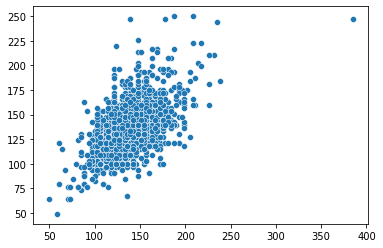

In [63]:
sns.scatterplot(dim1,dim2)

In [66]:
np.array(dim1).mean(), np.array(dim2).mean()

(135.844, 134.755)

In [136]:
img_shape= (130,130,3)

In [135]:
130*130*3

50700

so lets take 135,135,3 , while doing imagedata generator

In [79]:
img = glob(path+'train/parasitized/*')[0]
imread(img).max()  # already normalized, otherwise 1/255

0.8862745

In [137]:
img_gen = ImageDataGenerator(rotation_range=20,
                             width_shift_range=0.1,
                             height_shift_range = 0.1,
                             shear_range=0.1,
                             zoom_range=0.1,
                             horizontal_flip= True,
                             fill_mode = 'nearest')


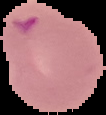

In [82]:
image.load_img(img)

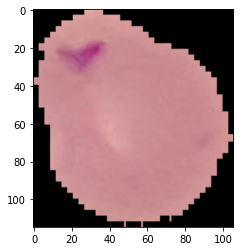

In [85]:
plt.imshow(imread(img))

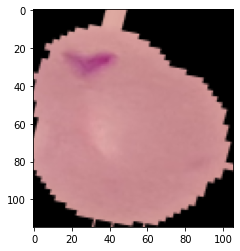

In [103]:
plt.imshow(img_gen.random_transform(imread(img)))

In [138]:
train_gen = img_gen.flow_from_directory(path+'train', 
                            target_size = img_shape[:2],
                            color_mode = 'rgb',
                            batch_size = 32,
                            class_mode = 'binary'
                            )

test_gen = img_gen.flow_from_directory(path+'test', 
                            target_size = img_shape[:2],
                            color_mode = 'rgb',
                            batch_size = 32,
                            class_mode = 'binary',
                            shuffle = False
                            )

Found 23273 images belonging to 2 classes.
Found 2600 images belonging to 2 classes.


In [119]:
train_gen.class_indices , test_gen.class_indices

({'parasitized': 0, 'uninfected': 1}, {'parasitized': 0, 'uninfected': 1})

Initializing the Model 

In [106]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, MaxPool2D, Flatten, Conv2D, Dropout

In [110]:
model = Sequential()
model.add(Conv2D(kernel_size=(3,3),filters=32, input_shape= img_shape, activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(kernel_size=(3,3),filters=64, activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(kernel_size=(3,3),filters=64, activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Flatten())

model.add(Dense(128,activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))

model.compile(loss= 'binary_crossentropy', optimizer = 'adam', metrics=['accuracy'])

In [112]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 133, 133, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 66, 66, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 30, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 15, 15, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 14400)            

In [113]:
from tensorflow.keras.callbacks import EarlyStopping

In [114]:
es = EarlyStopping(monitor='val_loss',patience=4)


In [120]:
result = model.fit(train_gen,epochs= 20, validation_data=test_gen,callbacks=[es])

Training will take lot of time, lets upload the already learned model.

In [139]:
pre_model=load_model('/content/drive/MyDrive/cell_images/malaria_detector.h5')

In [131]:
# pre_model.evaluate(test_gen)


In [140]:
pre_model.evaluate(test_gen)

82/82 [==============================] - 13s 158ms/step - loss: 35.8365 - accuracy: 0.8704


[35.8365364074707, 0.8703846335411072]

In [133]:
pre_model.metrics_names

['loss', 'accuracy']

In [142]:
pred = pre_model.predict(test_gen)

In [144]:
pred = pred > 0.5

In [145]:
pred

array([[False],
       [False],
       [False],
       ...,
       [ True],
       [False],
       [False]])

In [149]:
y_true = test_gen.classes

In [150]:
confusion_matrix(y_true,pred)

array([[1273,   27],
       [ 315,  985]])

In [152]:
print(classification_report(y_true,pred))

              precision    recall  f1-score   support

           0       0.80      0.98      0.88      1300
           1       0.97      0.76      0.85      1300

    accuracy                           0.87      2600
   macro avg       0.89      0.87      0.87      2600
weighted avg       0.89      0.87      0.87      2600



predicting the single image

In [177]:
img

'drive/MyDrive/cell_images/cell_images/train/parasitized/C99P60ThinF_IMG_20150918_141001_cell_113.png'

In [178]:
img_array = imread(img)

In [179]:
img_array.shape

(115, 106, 3)

In [180]:
img_array = cv2.resize(img_array,(130,130))

In [181]:
img_array.shape

(130, 130, 3)

In [185]:
img_pred=np.expand_dims(img_array, axis=0)

In [186]:
img_pred.shape

(1, 130, 130, 3)

In [191]:
pre_model.predict(img_pred).round(2) 

array([[0.02]], dtype=float32)

it is predicted as parasitized cell.

In [188]:
test_gen.class_indices

{'parasitized': 0, 'uninfected': 1}